# Strawberry Fields Forever  

_**exploring climate change impact on strawberry farming in Finland**_

**NOTE: This is a proof of concept**

*For "real" more effort is needed to ensure data correctness, addressing bias - and overall refactoring so that the script can be run as a whole. Furthermore, the specifics of strawberries from https://lansi-suomi.proagria.fi/sites/default/files/attachment/m._rantanen_mansikan_kukka-aiheiden_kehitys.pdf and N. Opstad et.al. /Scientia Horticuluturae 129 (2011) 127-134 should be integrated and some statistical analysis done*

Content

* [Purpose](#Purpose)
* [Data](#Data)
* [Explore Data](#explore_data)
* [Chosen Regions](#chosen_regions)
* [Explore by Region](#explore_region)
    * [Standard workflow](#explore_region_std)
    * [2011-2099 quick fix](#explore_region_long)
    * [Combine Data](#combine_data)
* [Mean Daily Temperature](#mean_daily_temp)
    * [2011-2099](#mean_daily_temp_2011_2099)
    * [2011-2041](#mean_daily_temp_2011_2041)
* [Accumulated temperature sum](#accum_temp_sum)
    * [Full year](#accum_temp_year)
    * [1st of May - 31 August - 2011-2099](#accum_temp_2011_2099)
    * [1st of May - 31 August - 2011-2041](#accum_temp_2011_2041)


* [Seasons for one lat/lon point only - experiment](#point_experiment)

# Purpose

Explore how climate change is expected to impact farming of strawberries in the South of Finland
(south from Tampere).

It is expected that strawberry varieties may have to change to better accommodate the 
projected climate over coming several decades.

Data for the study is from

* Agroclimatic Indicators / Copernicus Data Store (https://cds.climate.copernicus.eu/cdsapp#!/dataset/sis-agroclimatic-indicators?tab=overviewac)
* Key parameters for different strawberry varieties (tbd)



# Data

## Agroclimatic indicators

### Overview

As described in https://cds.climate.copernicus.eu/cdsapp#!/dataset/sis-agroclimatic-indicators?tab=overview

>This dataset provides agroclimatic indicators used to characterise plant-climate interactions for global agriculture. Agroclimatic indicators are useful in conveying climate variability and change in the terms that are meaningful to the agricultural sector. The objective of this dataset is to provide these indicators at a global scale in an easily accessible and usable format for further downstream analysis and the forcing of agricultural impact models.

>ERA-interim reanalysis and bias-corrected climate datasets have been used to generate the agroclimatic indicators for historical and future time periods. The input data was provided through the Inter-Sectoral Impact Model Intercomparison Project (ISIMIP), of which the ISIMIP Fast Track product was used. This product contains daily, biased-corrected, climate data from 5 CMIP5 General Circulation Models covering the period 1951-2099 (historical run up to 2005). The agroclimatic indicators were also generated using the WFDEI (Watch Forcing Data methodology applied to ERA-Interim) for the 1981-2010 climatological period. A total of 26 indicators are provided in this dataset at a spatial resolution of 0.5°x0.5° on a lat-lon grid. The temporal resolution of the variables differs depending on the indicator - they are available at 10 consecutive days (10-day), seasonal or annual resolution.

Details and usage guide of teh data set available as a separate pfd http://datastore.copernicus-climate.eu/documents/sis-global-agriculture/C3S422Lot1.WEnR.DS1_ProductUserGuideSpecification_v2.0.pdf

### Selected models

Data was chosen from the RCP4.5 experiment of all five models for the period from 
2011 up until end of 2070 (decadal, i.e. 10 days data up to 2041 only due to volume constraints)

* IPSL-CM5A-LR Model (IPSL, France)
* NorESM1-M Model (NCC, Norway)
* HadGEM2-ES Model (UK Met Office, UK)

The following were not used as they were not from Europe and therefore 
did not have necessarily Finland relevant focus  

* MIROC-ESM-CHEM Model (JAMSTEC, Japan)
* GFDL-ESM2M Model (NOAA, USA)

Several models were used to better understand uncertainty in projections.

In [63]:
model_list = [
    'NorESM1-M', 
#    'MIROC-ESM-CHEM', 
#    'GFDL-ESM2M', 
    'IPSL-CM5A-LR', 
    'HadGEM2-ES'
]

### Annual variables

This was not used as the definition was quite ambiguous in user manual. And it did not really match
the needs of our study as we needed data that we can relate to strawberries.

* GSL - Length of growing season

In [64]:
var_list_yr = ['GSL'] 


### Seasonal variables

Seasonal resolution data was available for the following variables

* Maximum number of consecutive dry days
* Maximum number of consecutive frost days
* Cold spell duration index
* Maximum number of consecutive summer days
* Maximum number of consecutive wet 
* Warm spell duration index
* Warm and wet days

However, in the end we did not use this data since it was hard to use in our context.

In [65]:
var_list_seasonal = ['CDD', 'CFD', 'CSDI', 'CSU', 'CWD', 'WSDI', 'WW']

Seasonal data has one value for each of the four three month  periods annually

* MAM - March, April, May
* JJA - June, July, August
* SON - September, October, November
* DJF - December, January, February

### Decadal variables (10 days aggregation)

In [66]:
var_list_dekadal_all = ['BEDD', 'DTR', 'RR', 'TG', 'TNn', 'TNx', 'TN', 'TXn', 'TXx', 'TX']
var_list_dekadal = ['TG', 'TX']


Out of the list we ended up using only two which we could easily use

* TG - Mean of daily mean temperature for the calculation of growing degree days
* TX - Mean of daily maximum temperature

The use of precipitation related or frost related variables might be useful in later studies, but not enough time for that nowe

### Processing

Data of each model was downloaded as zip files from CDS. It was provided as separate files which were consolidated into one for
ease of futher processing.

Note: Consolidation of netCDF4 files has issues which had to be resolved using a workaround
described at     # https://github.com/pydata/xarray/issues/2921

Even with that workaround one had to adjust dates of TX separately to get the results to
right range since TX and TG had issues of their own.
Or, to be frank, there was no time to build up enough expertise in the toolset 
and its proper use within constraints of time.


In [67]:
# root file for data, source files for different models in separate subfolders each
# combined files created into the root folder
#
# data_folder
#      |
#      +--/NorESM1-M
#      +--/IPSL-CM5A-LR
#      +--/HadGEM2-ES
#
data_folder = 'D:/Users/Juha/Ana/MyData/climate/strawberries/'

# going to create combined files or not?
do_combine = False
do_check = False

# some libraries we need
import matplotlib.pyplot as plt
# plots into the notebook
%matplotlib inline 
import netCDF4
import numpy as np
import xarray
import os

In [68]:
# Diagnostic script to check original unzipped files

# netCDF4 processing scripts are based on examples in 
# - https://medium.com/@neetinayak/combine-many-netcdf-files-into-a-single-file-with-python-469ba476fc14
# - https://iescoders.com/reading-netcdf4-data-in-python/

def check_model_files(data_folder, model, filter_txt = ''):
    file_list = os.listdir(data_folder + model)
    if filter_txt != '':
        file_list = [k for k in file_list if filter_txt in k]
    print(file_list)
    for afile in file_list:
        print('\n\n' + afile + '==================================================\n')
        rootgrp = netCDF4.Dataset(os.path.join(data_folder + model, afile), "r", format="NETCDF4")
        #print(rootgrp.data_model)
        print(rootgrp)
        print(rootgrp.dimensions)

        #for akey in rootgrp.variables.keys():
        #    print('\n' + akey + ' *************************************')
        #    v = rootgrp.variables[akey] 
        #    print(v) 

        rootgrp.close()


* * *

**Year**


In [69]:
if do_check: check_model_files(data_folder, model_list[1], '_yr_')

* * *

**Season**


In [70]:
if do_check: check_model_files(data_folder, model_list[1], '_season_')

* * *

**Dekadal**


In [71]:
if do_check: check_model_files(data_folder, model_list[1], '_dek_')

### Combining netCDF files

Can be done with the script here. 
But there are issues in combining the netCDF4 files and therefore there are a few 
quick and dirty adjustments later down in the script.

The unzipped files from Copernicus are assumed to be in subfolders named by the name of the model.
Combined files - if created - will be in the root folder.


In [72]:
do_combine = False

In [73]:
# Combine the unzipped files in subfolders into netCDF4 files in data root folder 
def get_var_details(ds, show_all = True):
    print(ds)
    if show_all:
        for akey in ds.variables.keys():
            print('\n' + akey + ' *************************************')
            v = ds.variables[akey] 
            print(v) 
        
def combine_to_netCDF4(folder, model, srctype, var):
        
    ds_cdd = xarray.open_mfdataset(
        folder + model + '/' + var + '*' + srctype + '*nc',
        combine = 'by_coords', 
        concat_dim="time"
    )
    
    print('\nbefore -------------------------------------------------------')
    get_var_details(ds_cdd)
        
    # https://github.com/pydata/xarray/issues/2921
    
    # make sure the encoding is really empty
    assert not ds_cdd.time.encoding

    # assign encoding, such that they are equal
    ds_cdd.time.encoding.update(ds_cdd.time_bounds.encoding)
    
    print('\nafter -------------------------------------------------------')
    get_var_details(ds_cdd)
        
    out_file = (
        folder + 
        model +
        '_' +
        srctype +
        '_' +
        var +
        '.nc'
    )

    print(out_file)
    
    ds_cdd.to_netcdf(out_file)
    ds_cdd.close()
    

In [74]:
# combining TG and TX together - takes a lot of time
if do_combine:
    for amodel in model_list:
        for avar in ['TX, 'TG']:
            print('\n\nCombining %s - feature %s\n\n' % (amodel, avar))
            combine_to_netCDF4(
                data_folder,
                amodel,
                'dek',
                avar
            )
        

In [75]:
def get_netCDF4_file(data_folder, 
                     model, 
                     avar, 
                     data_aggregation = 'season', 
                     timerange = '', 
                     print_debug = 0):
    """
    Get original or combined data sets
    
    At the moment easiest way to get netCDF4 dataset is to read it from  combined file.
    Note that metadata shown comes from the first of the earlier combined files.
    There probably is an easier / native way to do this, but not found it yet.
    
    Note: when finished with the file, use .close()
    """
    if timerange == '':
        if data_aggregation != '':
            data_aggregation = '_' + data_aggregation
        afile = data_folder + model + data_aggregation + '_' + avar + '.nc'
    else:
        afile = (
            data_folder + model + '/' + 
            avar.lower() + '_C3S-glob-agric_' +
            model.lower() + '_rcp4p5_' +
            data_aggregation + '_' +
            timerange +
            '_v1.nc')
            
    if print_debug > 0: print(afile)
    f = netCDF4.Dataset(
        afile, 
        "r", 
        format="NETCDF4"
    )
    if print_debug > 1: print(f.variables.keys())
    for akey in f.variables.keys():
        if print_debug > 2: print('\n' + akey + ' *************************************')
        v = f.variables[akey] 
        if print_debug > 2: print(v) 
        
    if print_debug > 1: print('\n**************************************')
    if print_debug > 1: print(f.variables.keys())
    
    return f

In [76]:
def getclosest_ij(lats, lons, latpt, lonpt):
    """
    function to find the index of the point closest
    (in squared distance) to give lat/lon value
    """
    # find squared distance of every point on grid
    lats_dist = (lats - latpt)**2
    lons_dist = (lons - lonpt)**2
    return lats_dist.argmin(), lons_dist.argmin() 

# Explore data<a id='explore_data'></a>

Working out first version of analysis using

* one coordinate point: Tampere lat = 61.4978° N, lon = 23.7610° E
* separate trend for each of the four seasons: JFM, AMJ, JAS, OND


In [77]:
geopoint_name = 'Tampere'
geopoint_lat = 61.4978
geopoint_lon = 23.7610

In [78]:
import seaborn as sns
import pandas as pd

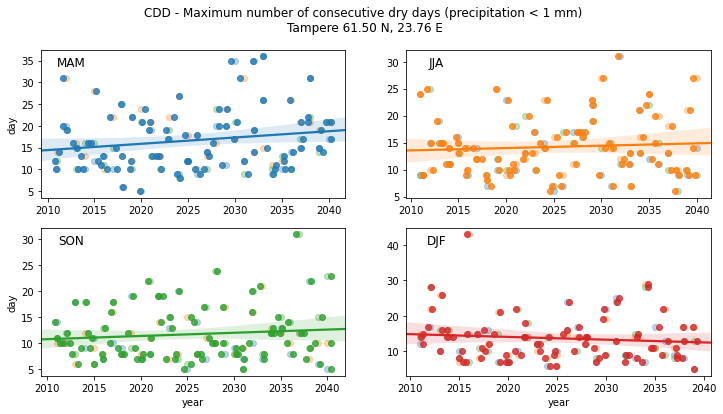

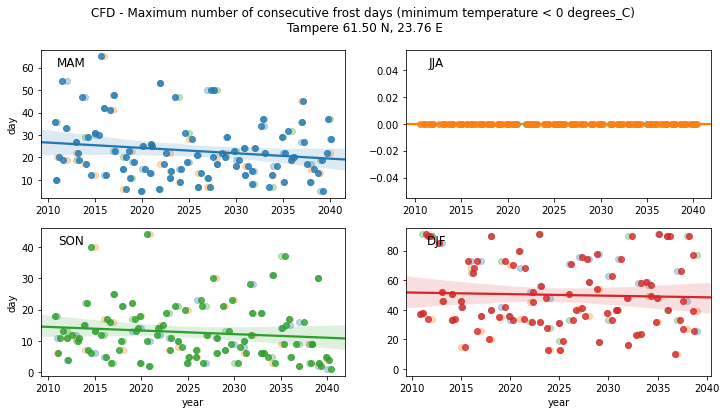

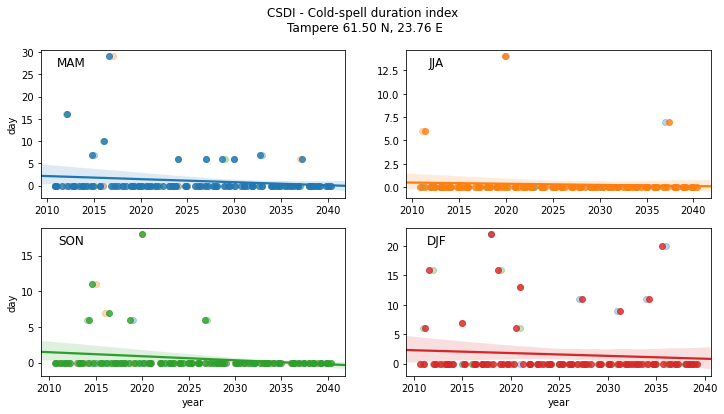

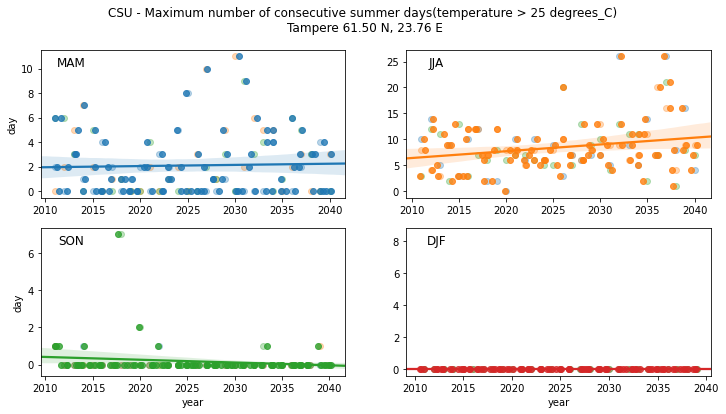

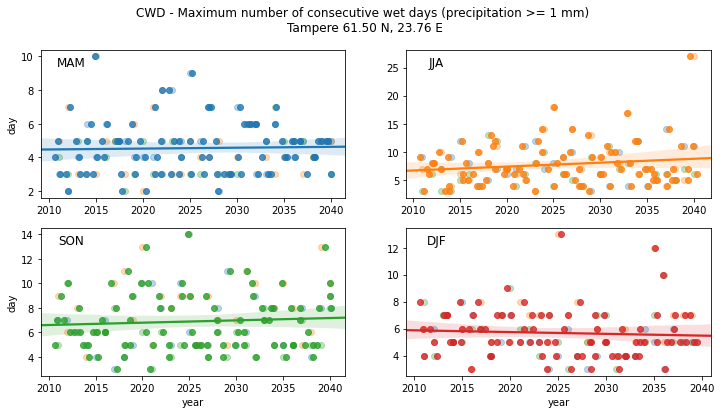

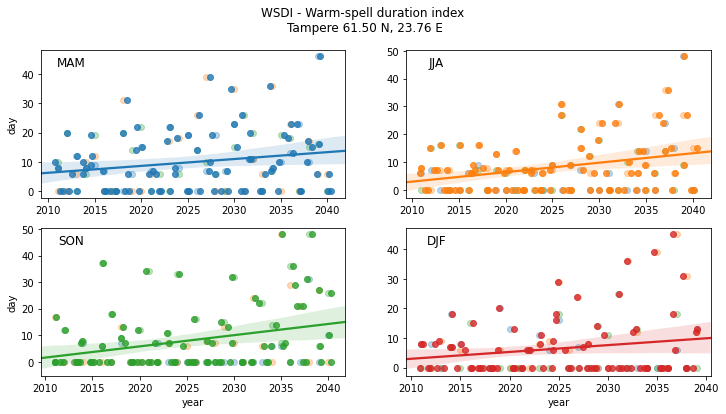

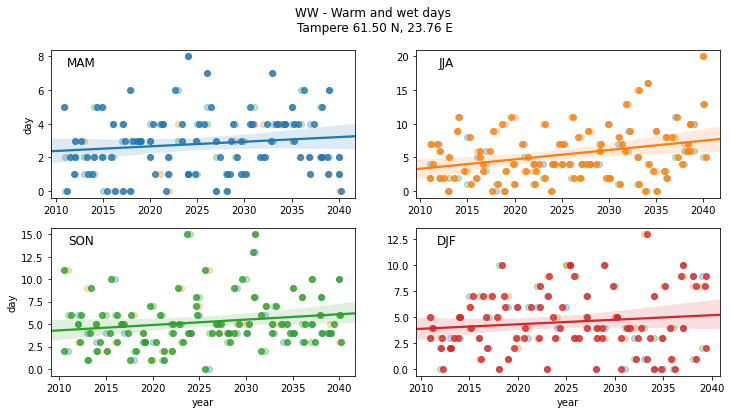

In [79]:
# First version of script for one point only

plt.rcParams['figure.figsize'] = [12, 6]

def do_model_variable(data_folder, models, thevars, geo_lat, geo_lon, geo_name, timerange = ''):
    """
    make analysis with variables and models listed for one single point
    """
    
    #print(models)
    #print(vars)
    #print('*******')
    
    for avar in thevars: 
        
        seasons = ['MAM', 'JJA', 'SON', 'DJF']
        subplots = [(0, 0), (0, 1), (1, 0), (1, 1)]
        title_txt = ''
        location = ''
        
        fig, axs = plt.subplots(2, 2)
        
        #fig=plt.figure(figsize=(24,16), dpi= 100, facecolor='w', edgecolor='k')

        for iseason in range(0, len(seasons)):
            
            season_dict = dict()
            
            season_v = []
            season_y = []
            
            for amodel in models:
                
                f = get_netCDF4_file(data_folder, amodel,  avar, 'season', timerange, 0)
                
                if location == '':
                    lat, lon = f.variables['lat'], f.variables['lon']
                    latvals = lat[:]
                    lonvals = lon[:] 
                    iy_min, ix_min = getclosest_ij(latvals, lonvals, geo_lat, geo_lon)
                    location = '%s %.2f N, %.2f E' % (geo_name, geo_lat, geo_lon)
                    v = f.variables[avar]
                    v_units = v.units
                    v_long_name = v.long_name
                    
                season_set = v[iseason::4,iy_min,ix_min].flatten()
                
                season_v.append(season_set.flatten())
                season_y.append(list(range(2011, 2011 + len(season_set))))
                
                season_dict[amodel] = season_set
                axs[subplots[iseason]].scatter(range(2011, 2011 + len(season_set)), season_set, label = amodel, alpha = 0.3)
                f.close()
                    
            if iseason in [0, 2]:
                axs[subplots[iseason]].set_ylabel(v_units)
            if iseason in [2, 3]:
                axs[subplots[iseason]].set_xlabel('year')
            axs[subplots[iseason]].set_title('%s' %  (seasons[iseason]), x = 0.1, y = 0.85)
            #axs[subplots[iseason]].legend()
            
            
            #data_season = pd.DataFrame({'y':season_v, 'x':season_y})
            sns.regplot(
                [item for sublist in season_y for item in sublist], 
                [item for sublist in season_v for item in sublist],
                ax = axs[subplots[iseason]],
                x_jitter = 0.45
            )

            
        fig.suptitle('%s - %s \n%s' %  (avar, v_long_name, location))
        plt.show()
                                
#do_model_variable(data_folder, model_list, var_list_seasonal, geopoint_lat, geopoint_lon, geopoint_name, '20410101-20701231') # NOTE: wrong start year shown
do_model_variable(data_folder, model_list, var_list_seasonal, geopoint_lat, geopoint_lon, geopoint_name, '20110101-20401231')
#do_model_variable(data_folder, model_list, var_list_seasonal, geopoint_lat, geopoint_lon, geopoint_name)    

# Chosen regions<a id='chosen_regions'></a>

Getting data for three separate regions of strawberry farming


* * *

Häme

![Häme](D:/Users/Juha/Ana/MyData/climate/strawberries/map_hame.png)

Koski TL

* 60.655
* 23.141667

Padasjoki

* 61.35000000
* 25.28333000

* * *

Pohjois Savo

![Pohjois Savo](D:/Users/Juha/Ana/MyData/climate/strawberries/map_psavo.png)

Hankasalmi

* 62.38666512 
* 26.43499826

Valtimo

* 63.68
* 28.816667

* * *

Varsinais-Suomi

![Varsinais-Suomi](D:/Users/Juha/Ana/MyData/climate/strawberries/map_vsuomi.png)


Houtskär

* 60.2167
* 21.3833

Alastaro

* 60.97424 
* 22.65558


In [80]:
# structures for later handling

geo_hame = {
    'name':'Häme',
    'gp1': {
        'name':'Koski TL',
        'lat_lon':[60.655, 23.141667]
    },
    'gp2': {
        'name':'Padasjoki',
        'lat_lon':[61.35000000, 25.28333000]
    }
}
#geo_hame['gp2']['lat_lon'][1]

geo_psavo = {
    'name':'Pohjois-Savo',
    'gp1': {
        'name':'Hankasalmi',
        'lat_lon':[62.38666512 , 26.43499826]
    },
    'gp2': {
        'name':'Valtimo',
        'lat_lon':[63.68, 28.816667]
    }
}

geo_vsuomi = {
    'name':'Varsinais-Suomi',
    'gp1': {
        'name':'Houtskär',
        'lat_lon':[60.2167 , 21.3833]
    },
    'gp2': {
        'name':'Alastaro',
        'lat_lon':[60.97424, 22.65558]
    }
}


# Explore by Region <a id='explore_region'></a>

Exploring by region and generating basic data summaries for later use


In [81]:
def geo_avg_ts(v, 
               iy1_min, 
               iy2_min, 
               ix1_min, 
               ix2_min, 
               t0 = 0, 
               t1 = 1e9, 
               dt = 1):
    """
    Getting average over geographical area, returning time series
    Assumes rectangular area!!
    """
    vt = []
    for it in range(t0, t1, dt):
        varsum = 0
        n = 0
        for iy in range(min(iy1_min, iy2_min), max(iy1_min, iy2_min)):
            for ix in range(min(ix1_min, ix2_min), max(ix1_min, ix2_min)):
                #print('(%.d, %.d, %d): %7.4f %s, (%.2f, %.2f)' % (iy, ix, it, v[it, iy, ix], v.units, latvals[iy], lonvals[ix]))            
                varsum = varsum + v[it, iy, ix]
                n = n + 1
        vt.append(varsum/n)
    return vt

def geo_avg_models(data_folder, 
                   models, 
                   thevars, 
                   data_aggregation, 
                   geo_name, 
                   gp1, 
                   gp2, 
                   timerange, 
                   t0, 
                   t1, 
                   dt,
                   tag,
                   do_plot = True):
    """
    Returning dataframe 
    """
    
    df_out = None
    
    from datetime import date, timedelta
    
    geo_name_txt = geo_name + ' [lat %.2f, lon %.2f x lat %.2f, lon %.2f]' % (gp1[0], gp1[1], gp2[0], gp2[1])
    
    for avar in thevars: 
        
        print(avar)
        
        geo_set = False
        
        v_model_v_ts = []
        v_model_t = []
        v_model_days_from1860 = []
        v_model_model = []
        var_id = []
        var_id_long = []
        var_id_units = []
        
        for amodel in models:
        
            #print('%s - %s' %(avar, amodel))
            
            f = get_netCDF4_file(data_folder, amodel,  avar, data_aggregation, timerange, 0)
            v = f.variables[avar]
            
            if not geo_set:
                
                # set common stuff for the variable
                
                v_time = f.variables['time']
                timevals = v_time[:] 
                                
                v_units = v.units
                v_long_name = v.long_name
                
                # assuming lat/lon the same for all models
                
                lat, lon = f.variables['lat'], f.variables['lon']
                latvals = lat[:]
                lonvals = lon[:]
                                
                iy1_min, ix1_min = getclosest_ij(latvals, lonvals, gp1[0], gp1[1])
                iy2_min, ix2_min = getclosest_ij(latvals, lonvals, gp2[0], gp2[1])
                
                geo_set = True
                
   
            #print('%s - %s, %s' %(avar, v_long_name, amodel))
    
            v_ts = geo_avg_ts(v, iy1_min, iy2_min, ix1_min, ix2_min, t0, t1, dt)

            f.close()
            
            v_model_v_ts.append(v_ts)
            v_model_t.append(list(range(0, len(v_ts))))
            v_model_days_from1860.append(timevals[list(range(t0, t1, dt))])
            v_model_model.append(np.repeat(amodel, len(v_ts), axis=0))
            var_id.append(np.repeat(avar, len(v_ts), axis=0))
            var_id_long.append(np.repeat(v_long_name, len(v_ts), axis=0))
            var_id_units.append(np.repeat(v_units, len(v_ts), axis=0))
        
        avar_df = pd.DataFrame({
            'var_id': [item for sublist in var_id for item in sublist],
            'var_name': [item for sublist in var_id_long for item in sublist],
            'var_unit': [item for sublist in var_id_units for item in sublist],
            'var': [item for sublist in v_model_v_ts for item in sublist],
            'time': [item for sublist in v_model_t for item in sublist],
            'days_from1860': [item for sublist in v_model_days_from1860 for item in sublist],
            'model': [item for sublist in v_model_model for item in sublist]
        })
        
        avar_df['days_from1860_td'] = pd.to_timedelta(avar_df['days_from1860'], 'day')        
        avar_df['datetime'] = avar_df['days_from1860_td'] + pd.to_datetime(date(1860, 1, 1))
        
        avar_df['datetime_int'] =  avar_df['datetime'].values.astype(float)/10**9
        avar_df['datetime_date'] =  pd.to_datetime(avar_df['datetime_int']*10**9)
        
        
        if df_out is None:
            df_out = avar_df.copy()
        else:            
            df_out = pd.concat([df_out, avar_df])

        #print(avar_df.info())
        #print(avar_df.head(10))

        if do_plot:
            
            ax = plt.gca()
            sns.regplot(
                x = 'datetime_int',
                y = 'var',
                data = avar_df,
                ax=ax
            )
            xticks = ax.get_xticks()
            ax.set_xticks(ax.get_xticks().tolist()) # REMOVE IN THE FUTURE - PLACED TO AVOID WARNING - IT IS A BUG FROM MATPLOTLIB 3.3.1
            xticks_dates = [pd.to_datetime(x*10**9).strftime('%Y-%m') for x in xticks]
            ax.set_xticklabels(xticks_dates)
            plt.title(avar + ' - ' + v_long_name + ' - ' + tag + '\n' + geo_name_txt)
            plt.xlabel('Models: ' + ', '.join(models))
            plt.ylabel(avar + ' ' + v_units)
            plt.show()

            #print(xticks_dates)
        
    return df_out

In [83]:
def get_region_title(geostr):
    return geostr['name'] + ' (' + geostr['gp1']['name'] + '-' +  geostr['gp2']['name'] + ')'
#get_region_title(geo_psavo)

## Standard workflow <a id='explore_region_std'></a>

Standard workflow for regions


GSL


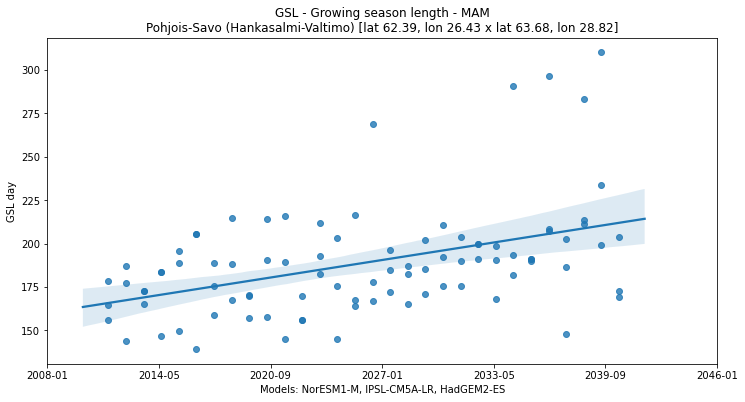

CDD
CFD
CSDI
CSU
CWD
WSDI
WW


,var_id,var_name,var_unit,var,time,days_from1860,model,days_from1860_td,datetime,datetime_int,datetime_date
0,CDD,Maximum number of consecutive dry days (precip...,day,8.866667,0,55257.0,NorESM1-M,55257 days,2011-04-16,1.302912e+09,2011-04-16
1,CDD,Maximum number of consecutive dry days (precip...,day,10.600000,1,55348.0,NorESM1-M,55348 days,2011-07-16,1.310774e+09,2011-07-16
2,CDD,Maximum number of consecutive dry days (precip...,day,11.800000,2,55440.0,NorESM1-M,55440 days,2011-10-16,1.318723e+09,2011-10-16
3,CDD,Maximum number of consecutive dry days (precip...,day,9.000000,3,55532.0,NorESM1-M,55532 days,2012-01-16,1.326672e+09,2012-01-16
4,CDD,Maximum number of consecutive dry days (precip...,day,14.600000,4,55623.0,NorESM1-M,55623 days,2012-04-16,1.334534e+09,2012-04-16


In [171]:
df_yr_psavo = geo_avg_models(
    data_folder, 
    model_list, 
    var_list_yr, 
    'yr',
    get_region_title(geo_psavo),
    geo_psavo['gp1']['lat_lon'], 
    geo_psavo['gp2']['lat_lon'], 
    '20110101-20401231', 
    0, 30, 1,
    'MAM',
    True
)

df_yr_psavo.to_pickle(data_folder + 'df_yr_psavo.pkl')
df_yr_psavo.head()

####

df_season_psavo = geo_avg_models(
    data_folder, 
    model_list, 
    var_list_seasonal, 
    'season',
    get_region_title(geo_psavo),
    geo_psavo['gp1']['lat_lon'], 
    geo_psavo['gp2']['lat_lon'], 
    '20110101-20401231', 
    0, 119, 1,
    'XXX',
    False
)

df_season_psavo.to_pickle(data_folder + 'df_season_psavo.pkl')
df_season_psavo.head()

In [85]:
df_season_psavo.loc[df_season_psavo['var_id'] == 'CDD'].head()

,var_id,var_name,var_unit,var,time,days_from1860,model,days_from1860_td,datetime,datetime_int,datetime_date
0,CDD,Maximum number of consecutive dry days (precip...,day,8.866667,0,55257.0,NorESM1-M,55257 days,2011-04-16,1.302912e+09,2011-04-16
1,CDD,Maximum number of consecutive dry days (precip...,day,10.600000,1,55348.0,NorESM1-M,55348 days,2011-07-16,1.310774e+09,2011-07-16
2,CDD,Maximum number of consecutive dry days (precip...,day,11.800000,2,55440.0,NorESM1-M,55440 days,2011-10-16,1.318723e+09,2011-10-16
3,CDD,Maximum number of consecutive dry days (precip...,day,9.000000,3,55532.0,NorESM1-M,55532 days,2012-01-16,1.326672e+09,2012-01-16
4,CDD,Maximum number of consecutive dry days (precip...,day,14.600000,4,55623.0,NorESM1-M,55623 days,2012-04-16,1.334534e+09,2012-04-16


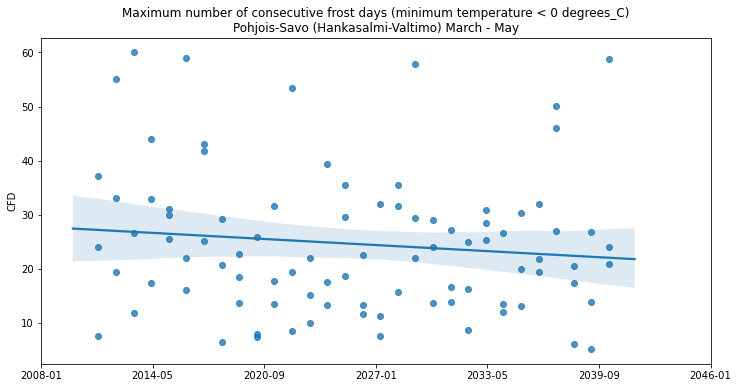

In [86]:
df = df_season_psavo.loc[
    (df_season_psavo['var_id'] == var_list_seasonal[1]) &
    (df_season_psavo['datetime'].dt.month == 4) 
]

ax = plt.gca()
sns.regplot(
    x = 'datetime_int',
    y = 'var',
    data = df,
    ax=ax
)
xticks = ax.get_xticks()
ax.set_xticks(ax.get_xticks().tolist()) # REMOVE IN THE FUTURE - PLACED TO AVOID WARNING - IT IS A BUG FROM MATPLOTLIB 3.3.1
xticks_dates = [pd.to_datetime(x*10**9).strftime('%Y-%m') for x in xticks]
ax.set_xticklabels(xticks_dates)
plt.xlabel('')
plt.title(df['var_name'][0] + '\n' + get_region_title(geo_psavo) + ' March - May')
plt.ylabel(df['var_id'][0])
plt.show()

In [87]:
df_season_psavo.head()

,var_id,var_name,var_unit,var,time,days_from1860,model,days_from1860_td,datetime,datetime_int,datetime_date
0,CDD,Maximum number of consecutive dry days (precip...,day,8.866667,0,55257.0,NorESM1-M,55257 days,2011-04-16,1.302912e+09,2011-04-16
1,CDD,Maximum number of consecutive dry days (precip...,day,10.600000,1,55348.0,NorESM1-M,55348 days,2011-07-16,1.310774e+09,2011-07-16
2,CDD,Maximum number of consecutive dry days (precip...,day,11.800000,2,55440.0,NorESM1-M,55440 days,2011-10-16,1.318723e+09,2011-10-16
3,CDD,Maximum number of consecutive dry days (precip...,day,9.000000,3,55532.0,NorESM1-M,55532 days,2012-01-16,1.326672e+09,2012-01-16
4,CDD,Maximum number of consecutive dry days (precip...,day,14.600000,4,55623.0,NorESM1-M,55623 days,2012-04-16,1.334534e+09,2012-04-16


In [88]:
dfx = df_season_psavo.copy()

dfx['mth'] = pd.DatetimeIndex(dfx['datetime']).month

dfx.groupby(['mth', 'var_id']).count()

var_name  var_unit  var  time  days_from1860  model  \
mth var_id                                                        
1   CDD           87        87   87    87             87     87   
    CFD           87        87   87    87             87     87   
    CSDI          87        87   87    87             87     87   
    CSU           87        87   87    87             87     87   
    CWD           87        87   87    87             87     87   
    WSDI          87        87   87    87             87     87   
    WW            87        87   87    87             87     87   
4   CDD           90        90   90    90             90     90   
    CFD           90        90   90    90             90     90   
    CSDI          90        90   90    90             90     90   
    CSU           90        90   90    90             90     90   
    CWD           90        90   90    90             90     90   
    WSDI          90        90   90    90             90     90   
    WW            90        90   90    90             90     90   
7   CDD           90        90   90    90             90     90   
    CFD           90        90   90    90             90     90   
    CSDI          90        90   90    90             90     90   
    CSU           90        90   90    90             90     90   
    CWD           90        90   90    90             90     90   
    WSDI          90        90   90    90             90     90   
    WW            90        90   90    90             90     90   
10  CDD           90        90   90    90             90     90   
    CFD           90        90   90    90             90     90   
    CSDI          90        90   90    90             90     90   
    CSU           90        90   90    90             90     90   
    CWD           90        90   90    90             90     90   
    WSDI          90        90   90    90             90     90   
    WW            90        90   90    90             90     90   

            days_from1860_td  datetime  datetime_int  datetime_date  
mth var_id                                                           
1   CDD                   87        87            87             87  
    CFD                   87        87            87             87  
    CSDI                  87        87            87             87  
    CSU                   87        87            87             87  
    CWD                   87        87            87             87  
    WSDI                  87        87            87             87  
    WW                    87        87            87             87  
4   CDD                   90        90            90             90  
    CFD                   90        90            90             90  
    CSDI                  90        90            90             90  
    CSU                   90        90            90             90  
    CWD                   90        90            90             90  
    WSDI                  90        90            90             90  
    WW                    90        90            90             90  
7   CDD                   90        90            90             90  
    CFD                   90        90            90             90  
    CSDI                  90        90            90             90  
    CSU                   90        90            90             90  
    CWD                   90        90            90             90  
    WSDI                  90        90            90             90  
    WW                    90        90            90             90  
10  CDD                   90        90            90             90  
    CFD                   90        90            90             90  
    CSDI                  90        90            90             90  
    CSU                   90        90            90             90  
    CWD                   90        90            90             90  
    WSDI                  90        90   

   var_id                                           var_name var_unit  \
0     CDD  Maximum number of consecutive dry days (precip...      day   
4     CDD  Maximum number of consecutive dry days (precip...      day   
8     CDD  Maximum number of consecutive dry days (precip...      day   
12    CDD  Maximum number of consecutive dry days (precip...      day   
16    CDD  Maximum number of consecutive dry days (precip...      day   

          var  time  days_from1860      model days_from1860_td   datetime  \
0    8.866667     0        55257.0  NorESM1-M       55257 days 2011-04-16   
4   14.600000     4        55623.0  NorESM1-M       55623 days 2012-04-16   
8   12.200000     8        55988.0  NorESM1-M       55988 days 2013-04-16   
12  12.600000    12        56353.0  NorESM1-M       56353 days 2014-04-16   
16   9.866667    16        56718.0  NorESM1-M       56718 days 2015-04-16   

    datetime_int datetime_date  
0   1.302912e+09    2011-04-16  
4   1.334534e+09    2012-04-16  

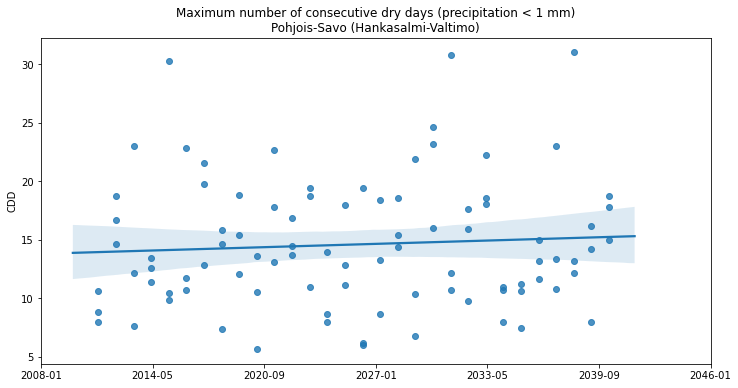

In [89]:
df = df_season_psavo.loc[
    (df_season_psavo['var_id'] == var_list_seasonal[0]) &
    ((df_season_psavo['datetime'].dt.month == 4))
]

print(df.head())

ax = plt.gca()
sns.regplot(
    x = 'datetime_int',
    y = 'var',
    data = df,
    ax=ax
)
xticks = ax.get_xticks()
ax.set_xticks(ax.get_xticks().tolist()) # REMOVE IN THE FUTURE - PLACED TO AVOID WARNING - IT IS A BUG FROM MATPLOTLIB 3.3.1
xticks_dates = [pd.to_datetime(x*10**9).strftime('%Y-%m') for x in xticks]
ax.set_xticklabels(xticks_dates)
plt.xlabel('')
plt.title(df['var_name'].iloc[0] + '\n' + get_region_title(geo_psavo) )
plt.ylabel(df['var_id'].iloc[0])
plt.show()

In [63]:
df_dekadal_psavo = geo_avg_models(
    data_folder, 
    model_list, 
    var_list_dekadal, 
    'dek',
    get_region_title(geo_psavo),
    geo_psavo['gp1']['lat_lon'], 
    geo_psavo['gp2']['lat_lon'], 
    '20110101-20401231', 
    0, 1080, 1,
    '1st week ',
    False
)
df_dekadal_psavo.to_pickle(data_folder + 'df_dekadal_psavo.pkl')


BEDD
DTR
RR
TG
TNn
TNx
TN
TXn
TXx
TX


GSL


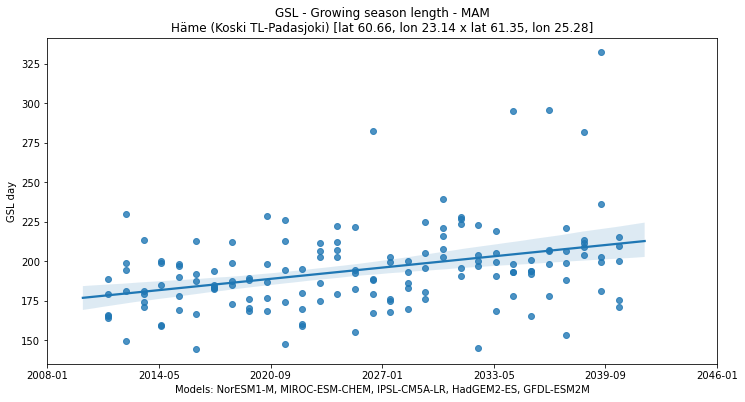

CDD
CFD
CSDI
CSU
CWD
WSDI
WW
BEDD
DTR
RR
TG
TNn
TNx
TN
TXn
TXx
TX
GSL


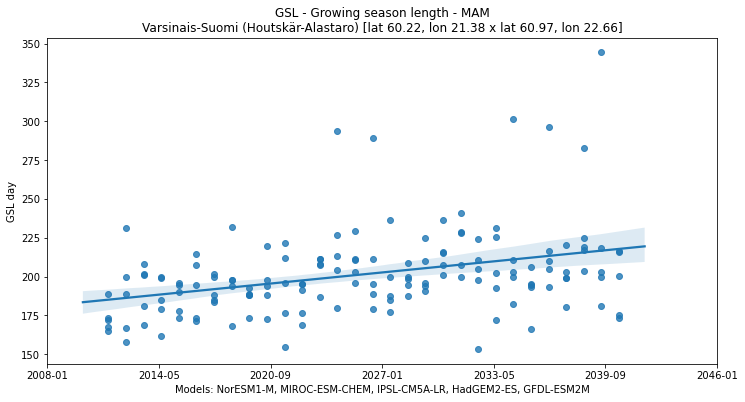

CDD
CFD
CSDI
CSU
CWD
WSDI
WW
BEDD
DTR
RR
TG
TNn
TNx
TN
TXn
TXx
TX


In [64]:
# häme

df_yr_hame = geo_avg_models(
    data_folder, 
    model_list, 
    var_list_yr, 
    'yr',
    get_region_title(geo_hame),
    geo_hame['gp1']['lat_lon'], 
    geo_hame['gp2']['lat_lon'], 
    '20110101-20401231', 
    0, 30, 1,
    'MAM',
    True
)
df_yr_hame.to_pickle(data_folder + 'df_yr_hame.pkl')

df_season_hame = geo_avg_models(
    data_folder, 
    model_list, 
    var_list_seasonal, 
    'season',
    get_region_title(geo_hame),
    geo_hame['gp1']['lat_lon'], 
    geo_hame['gp2']['lat_lon'], 
    '20110101-20401231', 
    0, 119, 1,
    'XXX',
    False
)
df_season_hame.to_pickle(data_folder + 'df_season_hame.pkl')

df_dekadal_hame = geo_avg_models(
    data_folder, 
    model_list, 
    var_list_dekadal, 
    'dek',
    get_region_title(geo_hame),
    geo_hame['gp1']['lat_lon'], 
    geo_hame['gp2']['lat_lon'], 
    '20110101-20401231', 
    0, 1080, 1,
    '1st week ',
    False
)
df_dekadal_hame.to_pickle(data_folder + 'df_dekadal_hame.pkl')

# varsinais suomi

df_yr_vsuomi = geo_avg_models(
    data_folder, 
    model_list, 
    var_list_yr, 
    'yr',
    get_region_title(geo_vsuomi),
    geo_vsuomi['gp1']['lat_lon'], 
    geo_vsuomi['gp2']['lat_lon'], 
    '20110101-20401231', 
    0, 30, 1,
    'MAM',
    True
)
df_yr_vsuomi.to_pickle(data_folder + 'df_yr_vsuomi.pkl')

df_season_vsuomi = geo_avg_models(
    data_folder, 
    model_list, 
    var_list_seasonal, 
    'season',
    get_region_title(geo_vsuomi),
    geo_vsuomi['gp1']['lat_lon'], 
    geo_vsuomi['gp2']['lat_lon'], 
    '20110101-20401231', 
    0, 119, 1,
    'XXX',
    False
)
df_season_vsuomi.to_pickle(data_folder + 'df_season_vsuomi.pkl')

df_dekadal_vsuomi = geo_avg_models(
    data_folder, 
    model_list, 
    var_list_dekadal, 
    'dek',
    get_region_title(geo_vsuomi),
    geo_vsuomi['gp1']['lat_lon'], 
    geo_vsuomi['gp2']['lat_lon'], 
    '20110101-20401231', 
    0, 1080, 1,
    '1st week ',
    False
)
df_dekadal_vsuomi.to_pickle(data_folder + 'df_dekadal_vsuomi.pkl')


In [ ]:
df_dekadal_psavo.to_pickle(data_folder + 'df_dekadal_psavo.pkl')

BEDD
DTR
RR
TG


## 2011-2099 quick fix <a id='explore_region_long'></a>

Quick insert for handling 2011-2099 case

In [91]:
df_dekadal_long_psavo_txtg = geo_avg_models(
    data_folder, 
    model_list, 
    ['TX', 'TG'], 
    'dek',
    get_region_title(geo_psavo),
    geo_psavo['gp1']['lat_lon'], 
    geo_psavo['gp2']['lat_lon'], 
    '', 
    0, 3204, 1,
    '1st week ',
    False
)
df_dekadal_long_psavo_txtg.to_pickle(data_folder + 'df_dekadal_long_psavo_txtg.pkl')
print(df_dekadal_long_psavo.head())
print(df_dekadal_long_psavo.tail())

####

df_dekadal_long_hame_txtg = geo_avg_models(
    data_folder, 
    model_list, 
    ['TX', 'TG'], 
    'dek',
    get_region_title(geo_hame),
    geo_hame['gp1']['lat_lon'], 
    geo_hame['gp2']['lat_lon'], 
    '', 
    0, 3204, 1,
    '1st week ',
    False
)

df_dekadal_long_hame_txtg.to_pickle(data_folder + 'df_dekadal_long_hame_txtg.pkl')

print(df_dekadal_long_hame_txtg.head())
print(df_dekadal_long_hame_txtg.tail())

####

df_dekadal_long_vsuomi_txtg = geo_avg_models(
    data_folder, 
    model_list, 
    ['TX', 'TG'], 
    'dek',
    get_region_title(geo_vsuomi),
    geo_vsuomi['gp1']['lat_lon'], 
    geo_vsuomi['gp2']['lat_lon'], 
    '', 
    0, 3204, 1,
    '1st week ',
    False
)
df_dekadal_long_vsuomi_txtg.to_pickle(data_folder + 'df_dekadal_long_vsuomi_txtg.pkl')

print(df_dekadal_long_vsuomi_txtg.head())
print(df_dekadal_long_vsuomi_txtg.tail())

## Combine Data <a id='combine_data'></a>

For ease of analysing, putting all data together


In [93]:
# Annual

def add_ids(df, region, srctype):
    df_out = df.copy()
    df_out['region'] = region
    df_out['srctype'] = srctype
    return df_out

### Standard

In [128]:
# year

df_yr_psavo2 = add_ids(df_yr_psavo, 'psavo', 'yr')
df_yr_vsuomi2 = add_ids(df_yr_vsuomi, 'vsuomi', 'yr')
df_yr_hame2 = add_ids(df_yr_hame, 'hame', 'yr')

df_yr = pd.concat([df_yr_psavo2, df_yr_vsuomi2,df_yr_hame2])
df_yr.head()

# Seasonal

df_season_psavo2 = add_ids(df_season_psavo, 'psavo', 'season')
df_season_vsuomi2 = add_ids(df_season_vsuomi, 'vsuomi', 'season')
df_season_hame2 = add_ids(df_season_hame, 'hame', 'season')

df_season = pd.concat([df_season_psavo2, df_season_vsuomi2,df_season_hame2])
df_season.head()

# Dekadal

df_dekadal_psavo2 = add_ids(df_dekadal_psavo, 'psavo', 'dekadal')
df_dekadal_vsuomi2 = add_ids(df_dekadal_vsuomi, 'vsuomi', 'dekadal')
df_dekadal_hame2 = add_ids(df_dekadal_hame, 'hame', 'dekadal')

df_dekadal = pd.concat([df_dekadal_psavo2, df_dekadal_vsuomi2, df_dekadal_hame2])
df_dekadal.head()

In [129]:
df_all = pd.concat([df_yr, df_season, df_dekadal])

In [132]:
df_all.groupby(['region', 'srctype', 'var_id'])['var'].count()

region  srctype  var_id
hame    dekadal  BEDD      5400
                 DTR       5400
                 RR        5400
                 TG        5400
                 TN        5400
                 TNn       5400
                 TNx       5400
                 TX        5400
                 TXn       5400
                 TXx       5400
        season   CDD        595
                 CFD        595
                 CSDI       595
                 CSU        595
                 CWD        595
                 WSDI       595
                 WW         595
        yr       GSL        150
psavo   dekadal  BEDD      5400
                 DTR       5400
                 RR        5400
                 TG        5400
                 TN        5400
                 TNn       5400
                 TNx       5400
                 TX        5400
                 TXn       5400
                 TXx       5400
        season   CDD        595
                 CFD        595
                

### 2011-2099 special case

In [94]:
# Dekadal long

df_dekadal_long = pd.concat([
    add_ids(df_dekadal_long_psavo_txtg, 'psavo', 'dekadal'), 
    add_ids(df_dekadal_long_vsuomi_txtg, 'vsuomi', 'dekadal'), 
    add_ids(df_dekadal_long_hame_txtg, 'hame', 'dekadal')
])

print(df_dekadal_long.head())
print(df_dekadal_long.tail())


  var_id                           var_name var_unit         var  time  \
0     TX  Mean of daily maximum temperature        K  258.091709     0   
1     TX  Mean of daily maximum temperature        K  257.797017     1   
2     TX  Mean of daily maximum temperature        K  270.968522     2   
3     TX  Mean of daily maximum temperature        K  269.902659     3   
4     TX  Mean of daily maximum temperature        K  268.963298     4   

   days_from1860      model days_from1860_td   datetime  datetime_int  \
0            0.0  NorESM1-M           0 days 1860-01-01 -3.471293e+09   
1           10.0  NorESM1-M          10 days 1860-01-11 -3.470429e+09   
2           20.0  NorESM1-M          20 days 1860-01-21 -3.469565e+09   
3           31.0  NorESM1-M          31 days 1860-02-01 -3.468614e+09   
4           41.0  NorESM1-M          41 days 1860-02-11 -3.467750e+09   

  datetime_date region  srctype  
0    1860-01-01  psavo  dekadal  
1    1860-01-11  psavo  dekadal  
2    1860-01-2

# Mean Daily Temperature <a id='mean_daily_temp'></a>


In [256]:
import strawberry as sbry

## 2011-2099 <a id='mean_daily_temp_2011_2099'></a>


                            OLS Regression Results                            
Dep. Variable:                    var   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     30.88
Date:                Sat, 12 Sep 2020   Prob (F-statistic):           3.74e-08
Time:                        22:44:00   Log-Likelihood:                -2016.5
No. Observations:                 801   AIC:                             4037.
Df Residuals:                     799   BIC:                             4046.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           24.9163      0.291     85.661   

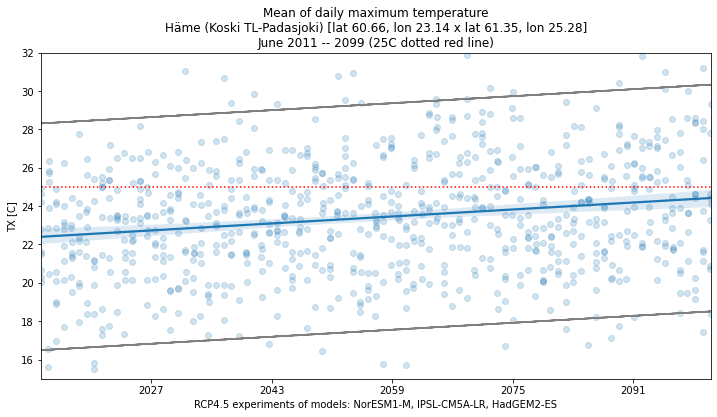

In [296]:
# dekadal long
import importlib
importlib.reload(sbry)

timeadjust = 4.82
xtra_txt = '\nJune 2011 -- 2099 (25C dotted red line)'

df = df_dekadal_long.loc[
    (df_dekadal_long['var_id'] == 'TX') &
    (df_dekadal_long['region'].isin(['hame'])) &
    ((df_dekadal_long['datetime'].dt.month.isin([6])))
]

sbry.quick_plot(df, geo_hame, xtra_txt, 25, timeadjust)

                            OLS Regression Results                            
Dep. Variable:                    var   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     31.82
Date:                Sat, 12 Sep 2020   Prob (F-statistic):           2.34e-08
Time:                        22:44:35   Log-Likelihood:                -2011.8
No. Observations:                 801   AIC:                             4028.
Df Residuals:                     799   BIC:                             4037.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           24.4359      0.289     84.499   

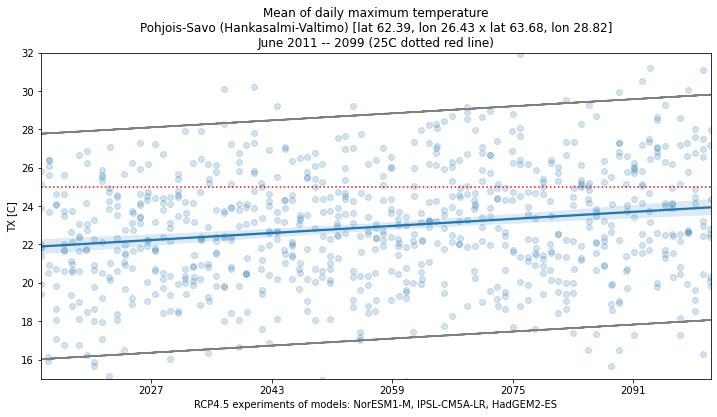

In [297]:
df = df_dekadal_long.loc[
    (df_dekadal_long['var_id'] == 'TX') &
    (df_dekadal_long['region'].isin(['psavo'])) &
    ((df_dekadal_long['datetime'].dt.month.isin([6])))
]

sbry.quick_plot(df, geo_psavo, xtra_txt, 25, timeadjust)

                            OLS Regression Results                            
Dep. Variable:                    var   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     39.67
Date:                Sat, 12 Sep 2020   Prob (F-statistic):           4.95e-10
Time:                        22:44:57   Log-Likelihood:                -1890.0
No. Observations:                 801   AIC:                             3784.
Df Residuals:                     799   BIC:                             3793.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           24.0243      0.248     96.727   

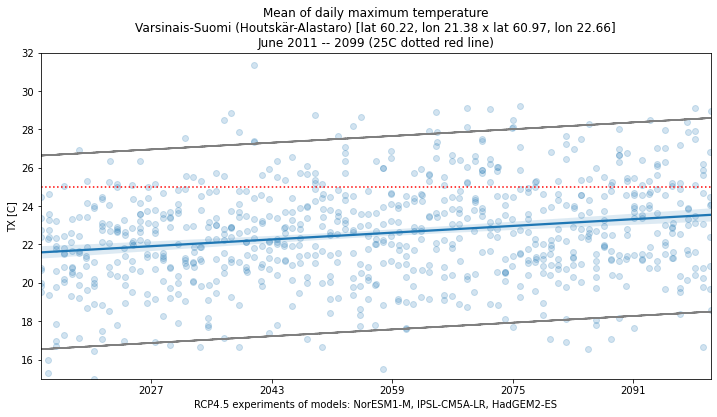

In [298]:
df = df_dekadal_long.loc[
    (df_dekadal_long['var_id'] == 'TX') &
    (df_dekadal_long['region'].isin(['vsuomi'])) &
    ((df_dekadal_long['datetime'].dt.month.isin([6])))
]

sbry.quick_plot(df, geo_vsuomi, xtra_txt, 25, timeadjust)

## 2011-2041 <a id='mean_daily_temp_2011_2041'></a>


In [ ]:
df = df_all.loc[
    (df_all['var_id'] == 'TX') &
    (df_all['region'].isin(['psavo'])) &
    ((df_all['datetime'].dt.month.isin([6])))
]

quick_plot(df, geo_psavo, '\nJune (25C dotted red line)', 25)

df = df_all.loc[
    (df_all['var_id'] == 'TX') &
    (df_all['region'].isin(['vsuomi'])) &
    ((df_all['datetime'].dt.month.isin([6])))
]
quick_plot(df, geo_vsuomi, '\nJune (25C dotted red line)', 25)

C:\Users\Juha\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Juha\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


   var_id                           var_name var_unit        var  time  \
15     TX  Mean of daily maximum temperature        C  21.672714    15   
16     TX  Mean of daily maximum temperature        C  21.481560    16   
17     TX  Mean of daily maximum temperature        C  24.970001    17   
51     TX  Mean of daily maximum temperature        C  15.608261    51   
52     TX  Mean of daily maximum temperature        C  25.247070    52   

    days_from1860      model days_from1860_td   datetime  datetime_int  \
15        55307.0  NorESM1-M       55307 days 2011-06-05  1.307232e+09   
16        55317.0  NorESM1-M       55317 days 2011-06-15  1.308096e+09   
17        55327.0  NorESM1-M       55327 days 2011-06-25  1.308960e+09   
51        55673.0  NorESM1-M       55673 days 2012-06-05  1.338854e+09   
52        55683.0  NorESM1-M       55683 days 2012-06-15  1.339718e+09   

   datetime_date region  srctype  
15    2011-06-05   hame  dekadal  
16    2011-06-15   hame  dekadal  
17   

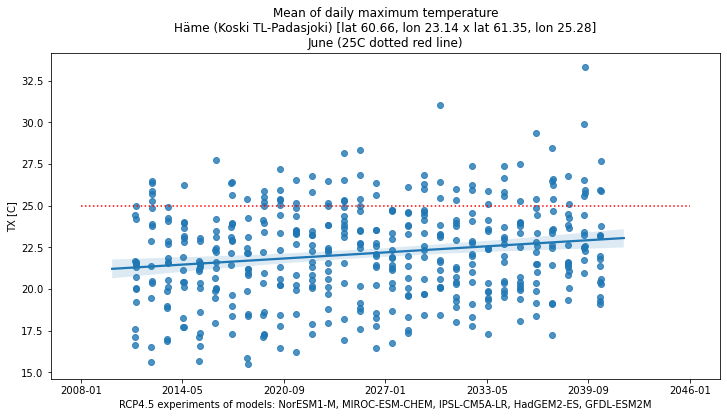

C:\Users\Juha\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Juha\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


   var_id                           var_name var_unit        var  time  \
15     TX  Mean of daily maximum temperature        C  21.354871    15   
16     TX  Mean of daily maximum temperature        C  21.891797    16   
17     TX  Mean of daily maximum temperature        C  25.168715    17   
51     TX  Mean of daily maximum temperature        C  15.932640    51   
52     TX  Mean of daily maximum temperature        C  26.390415    52   

    days_from1860      model days_from1860_td   datetime  datetime_int  \
15        55307.0  NorESM1-M       55307 days 2011-06-05  1.307232e+09   
16        55317.0  NorESM1-M       55317 days 2011-06-15  1.308096e+09   
17        55327.0  NorESM1-M       55327 days 2011-06-25  1.308960e+09   
51        55673.0  NorESM1-M       55673 days 2012-06-05  1.338854e+09   
52        55683.0  NorESM1-M       55683 days 2012-06-15  1.339718e+09   

   datetime_date region  srctype  
15    2011-06-05  psavo  dekadal  
16    2011-06-15  psavo  dekadal  
17   

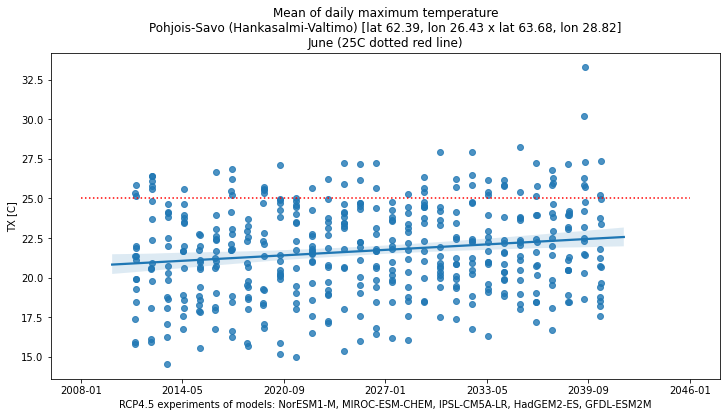

C:\Users\Juha\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Juha\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


   var_id                           var_name var_unit        var  time  \
15     TX  Mean of daily maximum temperature        C  20.329498    15   
16     TX  Mean of daily maximum temperature        C  19.977498    16   
17     TX  Mean of daily maximum temperature        C  23.393748    17   
51     TX  Mean of daily maximum temperature        C  15.319550    51   
52     TX  Mean of daily maximum temperature        C  22.388550    52   

    days_from1860      model days_from1860_td   datetime  datetime_int  \
15        55307.0  NorESM1-M       55307 days 2011-06-05  1.307232e+09   
16        55317.0  NorESM1-M       55317 days 2011-06-15  1.308096e+09   
17        55327.0  NorESM1-M       55327 days 2011-06-25  1.308960e+09   
51        55673.0  NorESM1-M       55673 days 2012-06-05  1.338854e+09   
52        55683.0  NorESM1-M       55683 days 2012-06-15  1.339718e+09   

   datetime_date  region  srctype  
15    2011-06-05  vsuomi  dekadal  
16    2011-06-15  vsuomi  dekadal  
17

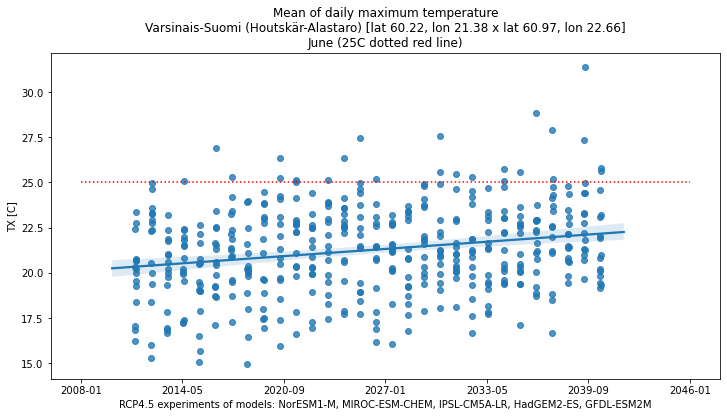

In [257]:
df = df_all.loc[
    (df_all['var_id'] == 'TX') &
    (df_all['region'].isin(['hame'])) &
    ((df_all['datetime'].dt.month.isin([6])))
]

quick_plot(df, geo_hame, '\nJune (25C dotted red line)', 25)

df = df_all.loc[
    (df_all['var_id'] == 'TX') &
    (df_all['region'].isin(['psavo'])) &
    ((df_all['datetime'].dt.month.isin([6])))
]

quick_plot(df, geo_psavo, '\nJune (25C dotted red line)', 25)

df = df_all.loc[
    (df_all['var_id'] == 'TX') &
    (df_all['region'].isin(['vsuomi'])) &
    ((df_all['datetime'].dt.month.isin([6])))
]
quick_plot(df, geo_vsuomi, '\nJune (25C dotted red line)', 25)

# Accumulated temperature sum <a id='accum_temp_sum'></a>



In [168]:
def quick_plot_accum(df, 
                     xvar, 
                     yvar, 
                     geostr, 
                     var_name, 
                     var_unit, 
                     txt = '', 
                     hline = None):
    
    geo_name_txt = (
        get_region_title(geostr) + 
        ' [lat %.2f, lon %.2f x lat %.2f, lon %.2f]' % 
        (
            geostr['gp1']['lat_lon'][0], 
            geostr['gp1']['lat_lon'][1], 
            geostr['gp2']['lat_lon'][0], 
            geostr['gp2']['lat_lon'][1]
        )
    )
    
    title_txt = var_name + '\n' + geo_name_txt + txt
    
    model_list = df['model'].unique()
            
    print(df.head())

    ax = plt.gca()
    sns.regplot(
        x = xvar,
        y = yvar,
        data = df, 
        scatter_kws={'alpha':0.2},
        ax=ax
    )
    xticks = ax.get_xticks()
    plt.xlabel('RCP4.5 experiments of models: ' + ', '.join(model_list))
    plt.title(title_txt)
    plt.ylabel(yvar + ' [' + var_unit + ']')
    if hline is not None:
        plt.hlines(hline, xmin = xticks[0], xmax = xticks[-1], linestyles='dotted', color='red')
    plt.xlim(df[xvar].min(), df[xvar].max())
    plt.ylim(1100, 1800)
    plt.show()

## Full year <a id='accum_temp_year'></a>

Fairly close to te official data for 2019 at https://www.ilmatieteenlaitos.fi/kasvukausi-2019

In [259]:
T_base = 5
df = df_all.loc[
    (df_all['var_id'] == 'TG')  #& ((df_all['datetime'].dt.month.isin([5])))
][['datetime', 'var', 'model', 'region', 'srctype']]
df['year'] = df['datetime'].dt.year
df['TG_C'] = df['var'] - 273
# each TG is from decadal data (for a 10 day period) ==> 10 * to get it (roughly) for whole year
df['GDD'] = [10*(x-T_base) if x > T_base else 0  for x in df['TG_C']]
print(df.head(10))

    datetime         var      model region  srctype  year       TG_C  GDD
0 2011-01-05  255.089951  NorESM1-M  psavo  dekadal  2011 -17.910049  0.0
1 2011-01-15  252.287477  NorESM1-M  psavo  dekadal  2011 -20.712523  0.0
2 2011-01-25  266.663320  NorESM1-M  psavo  dekadal  2011  -6.336680  0.0
3 2011-02-05  266.250922  NorESM1-M  psavo  dekadal  2011  -6.749078  0.0
4 2011-02-15  264.080629  NorESM1-M  psavo  dekadal  2011  -8.919371  0.0
5 2011-02-25  266.671358  NorESM1-M  psavo  dekadal  2011  -6.328642  0.0
6 2011-03-05  269.586945  NorESM1-M  psavo  dekadal  2011  -3.413055  0.0
7 2011-03-15  275.876294  NorESM1-M  psavo  dekadal  2011   2.876294  0.0
8 2011-03-25  272.299251  NorESM1-M  psavo  dekadal  2011  -0.700749  0.0
9 2011-04-05  276.937569  NorESM1-M  psavo  dekadal  2011   3.937569  0.0


        model  year          GDD
0  GFDL-ESM2M  2011  1334.440231
1  GFDL-ESM2M  2012  1594.186401
2  GFDL-ESM2M  2013  1416.685410
3  GFDL-ESM2M  2014  1513.103867
4  GFDL-ESM2M  2015  1564.546204


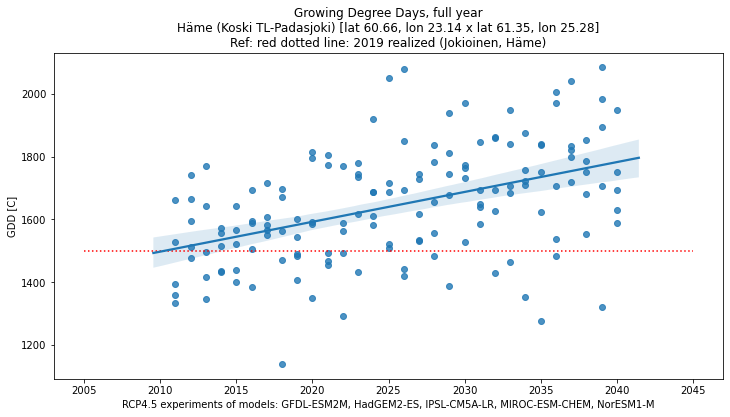

        model  year          GDD
0  GFDL-ESM2M  2011  1300.517619
1  GFDL-ESM2M  2012  1491.800151
2  GFDL-ESM2M  2013  1340.524801
3  GFDL-ESM2M  2014  1525.826233
4  GFDL-ESM2M  2015  1561.597371


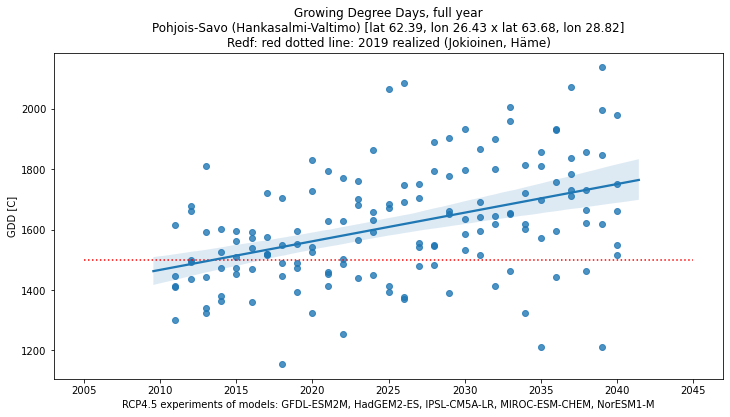

        model  year          GDD
0  GFDL-ESM2M  2011  1375.108439
1  GFDL-ESM2M  2012  1641.622721
2  GFDL-ESM2M  2013  1522.776184
3  GFDL-ESM2M  2014  1543.941142
4  GFDL-ESM2M  2015  1564.182943


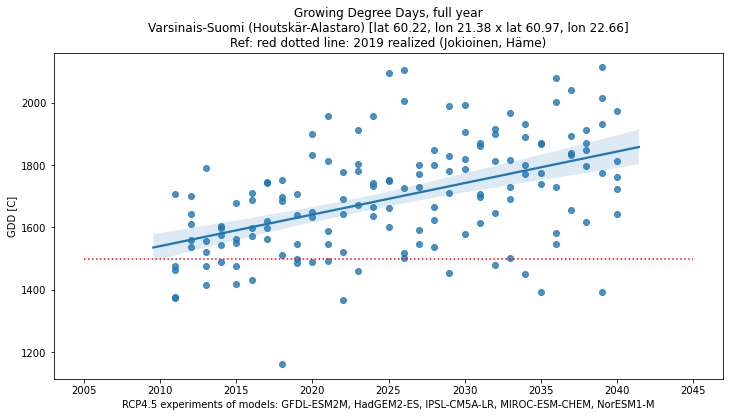

In [260]:
df_grp = df.loc[df['region'] == 'hame'].groupby(['model', 'year'], as_index=False)['GDD'].sum()
quick_plot_accum(df_grp, 'year', 'GDD', geo_hame, 'Growing Degree Days, full year', 'C', '\nRef: red dotted line: 2019 realized (Jokioinen, Häme)', 1500)
df_grp = df.loc[df['region'] == 'psavo'].groupby(['model', 'year'], as_index=False)['GDD'].sum()
quick_plot_accum(df_grp, 'year', 'GDD', geo_psavo, 'Growing Degree Days, full year', 'C', '\nRedf: red dotted line: 2019 realized (Jokioinen, Häme)', 1500)
df_grp = df.loc[df['region'] == 'vsuomi'].groupby(['model', 'year'], as_index=False)['GDD'].sum()
quick_plot_accum(df_grp, 'year', 'GDD', geo_vsuomi, 'Growing Degree Days, full year', 'C', '\nRef: red dotted line: 2019 realized (Jokioinen, Häme)', 1500)

## 1st of May - 31 August - 2011-2099 <a id='accum_temp_2011_2099'></a>

The function 'quick_plot_accum' checked with this data set

In [299]:
T_base = 5
df = df_dekadal_long.loc[
    (df_dekadal_long['var_id'] == 'TG') & ((df_dekadal_long['datetime'].dt.month.isin([5, 6, 7, 8])))
][['datetime', 'var', 'model', 'region', 'srctype']]
df['year'] = df['datetime'].dt.year
df['TG_C'] = df['var'] - 273
# each TG is from decadal data (for a 10 day period) ==> 10 * to get it (roughly) for whole year
df['GDD'] = [10*(x-T_base) if x > T_base else 0  for x in df['TG_C']]
print(df.head(10))

     datetime         var      model region  srctype  year       TG_C  \
12 2011-05-05  277.263694  NorESM1-M  psavo  dekadal  2011   4.263694   
13 2011-05-15  287.142450  NorESM1-M  psavo  dekadal  2011  14.142450   
14 2011-05-25  287.547015  NorESM1-M  psavo  dekadal  2011  14.547015   
15 2011-06-05  289.739296  NorESM1-M  psavo  dekadal  2011  16.739296   
16 2011-06-15  289.672721  NorESM1-M  psavo  dekadal  2011  16.672721   
17 2011-06-25  293.034027  NorESM1-M  psavo  dekadal  2011  20.034027   
18 2011-07-05  290.556276  NorESM1-M  psavo  dekadal  2011  17.556276   
19 2011-07-15  293.747351  NorESM1-M  psavo  dekadal  2011  20.747351   
20 2011-07-25  292.598643  NorESM1-M  psavo  dekadal  2011  19.598643   
21 2011-08-05  289.480347  NorESM1-M  psavo  dekadal  2011  16.480347   

           GDD  
12    0.000000  
13   91.424500  
14   95.470154  
15  117.392965  
16  116.727214  
17  150.340271  
18  125.562764  
19  157.473511  
20  145.986430  
21  114.803467  


        model  year          GDD
0  HadGEM2-ES  2011  1236.059570
1  HadGEM2-ES  2012  1448.772202
2  HadGEM2-ES  2013  1372.564697
3  HadGEM2-ES  2014  1144.610291
4  HadGEM2-ES  2015  1381.435242
                            OLS Regression Results                            
Dep. Variable:                    GDD   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.332
Method:                 Least Squares   F-statistic:                     133.0
Date:                Sat, 12 Sep 2020   Prob (F-statistic):           3.30e-25
Time:                        23:05:33   Log-Likelihood:                -1689.9
No. Observations:                 267   AIC:                             3384.
Df Residuals:                     265   BIC:                             3391.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
            

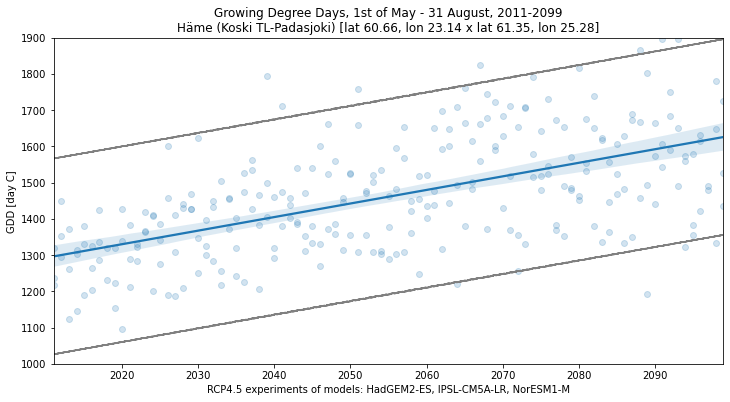

        model  year          GDD
0  HadGEM2-ES  2011  1205.822876
1  HadGEM2-ES  2012  1423.975138
2  HadGEM2-ES  2013  1349.745626
3  HadGEM2-ES  2014  1146.671346
4  HadGEM2-ES  2015  1370.942708
                            OLS Regression Results                            
Dep. Variable:                    GDD   R-squared:                       0.369
Model:                            OLS   Adj. R-squared:                  0.367
Method:                 Least Squares   F-statistic:                     155.2
Date:                Sat, 12 Sep 2020   Prob (F-statistic):           2.34e-28
Time:                        23:05:35   Log-Likelihood:                -1679.5
No. Observations:                 267   AIC:                             3363.
Df Residuals:                     265   BIC:                             3370.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
            

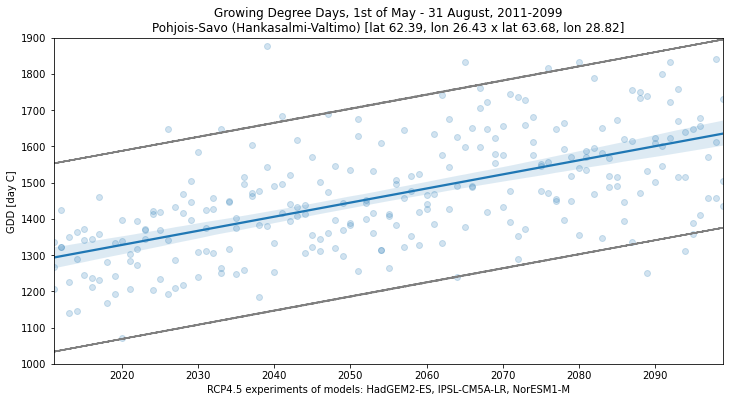

        model  year          GDD
0  HadGEM2-ES  2011  1177.672526
1  HadGEM2-ES  2012  1333.393962
2  HadGEM2-ES  2013  1198.877055
3  HadGEM2-ES  2014  1261.903280
4  HadGEM2-ES  2015  1396.088257
                            OLS Regression Results                            
Dep. Variable:                    GDD   R-squared:                       0.342
Model:                            OLS   Adj. R-squared:                  0.340
Method:                 Least Squares   F-statistic:                     138.0
Date:                Sat, 12 Sep 2020   Prob (F-statistic):           6.23e-26
Time:                        23:05:36   Log-Likelihood:                -1674.9
No. Observations:                 267   AIC:                             3354.
Df Residuals:                     265   BIC:                             3361.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
            

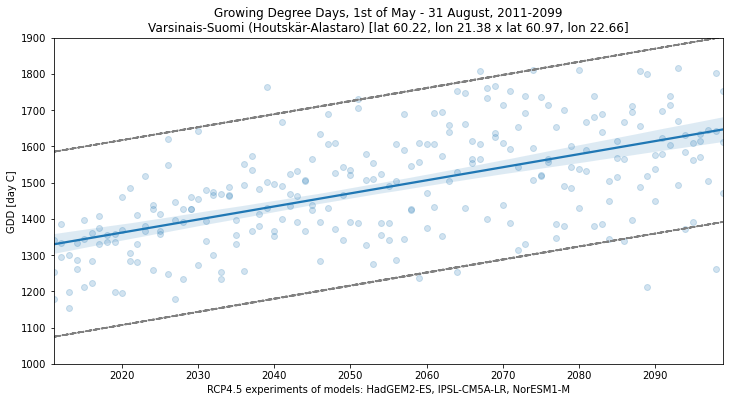

In [304]:
importlib.reload(sbry)

var_name = 'Growing Degree Days, 1st of May - 31 August, 2011-2099'
var_unit = 'day C'
df_grp = df.loc[df['region'] == 'hame'].groupby(['model', 'year'], as_index=False)['GDD'].sum()
sbry.quick_plot_accum(df_grp, 'year', 'GDD', geo_hame, var_name, var_unit, '')
df_grp = df.loc[df['region'] == 'psavo'].groupby(['model', 'year'], as_index=False)['GDD'].sum()
sbry.quick_plot_accum(df_grp, 'year', 'GDD', geo_psavo, var_name, var_unit, '')
df_grp = df.loc[df['region'] == 'vsuomi'].groupby(['model', 'year'], as_index=False)['GDD'].sum()
sbry.quick_plot_accum(df_grp, 'year', 'GDD', geo_vsuomi, var_name, var_unit, '')

## 1st of May - 31 August - 2011-2041 <a id='accum_temp_2011_2041'></a>

Earlier run part, not checked/run in the latest iteration


In [261]:
T_base = 5
df = df_all.loc[
    (df_all['var_id'] == 'TG') & ((df_all['datetime'].dt.month.isin([5, 6, 7, 8])))
][['datetime', 'var', 'model', 'region', 'srctype']]
df['year'] = df['datetime'].dt.year
df['TG_C'] = df['var'] - 273
# each TG is from decadal data (for a 10 day period) ==> 10 * to get it (roughly) for whole year
df['GDD'] = [10*(x-T_base) if x > T_base else 0  for x in df['TG_C']]
print(df.head(10))

     datetime         var      model region  srctype  year       TG_C  \
12 2011-05-05  277.263694  NorESM1-M  psavo  dekadal  2011   4.263694   
13 2011-05-15  287.142450  NorESM1-M  psavo  dekadal  2011  14.142450   
14 2011-05-25  287.547015  NorESM1-M  psavo  dekadal  2011  14.547015   
15 2011-06-05  289.739296  NorESM1-M  psavo  dekadal  2011  16.739296   
16 2011-06-15  289.672721  NorESM1-M  psavo  dekadal  2011  16.672721   
17 2011-06-25  293.034027  NorESM1-M  psavo  dekadal  2011  20.034027   
18 2011-07-05  290.556276  NorESM1-M  psavo  dekadal  2011  17.556276   
19 2011-07-15  293.747351  NorESM1-M  psavo  dekadal  2011  20.747351   
20 2011-07-25  292.598643  NorESM1-M  psavo  dekadal  2011  19.598643   
21 2011-08-05  289.480347  NorESM1-M  psavo  dekadal  2011  16.480347   

           GDD  
12    0.000000  
13   91.424500  
14   95.470154  
15  117.392965  
16  116.727214  
17  150.340271  
18  125.562764  
19  157.473511  
20  145.986430  
21  114.803467  


        model  year          GDD
0  GFDL-ESM2M  2011  1103.326569
1  GFDL-ESM2M  2012  1209.445877
2  GFDL-ESM2M  2013  1110.008774
3  GFDL-ESM2M  2014  1275.435944
4  GFDL-ESM2M  2015  1314.206085


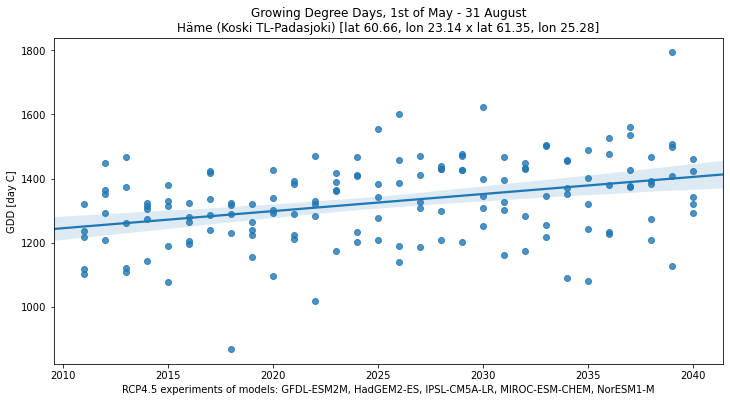

        model  year          GDD
0  GFDL-ESM2M  2011  1125.693990
1  GFDL-ESM2M  2012  1192.385600
2  GFDL-ESM2M  2013  1119.325724
3  GFDL-ESM2M  2014  1297.291585
4  GFDL-ESM2M  2015  1339.465332


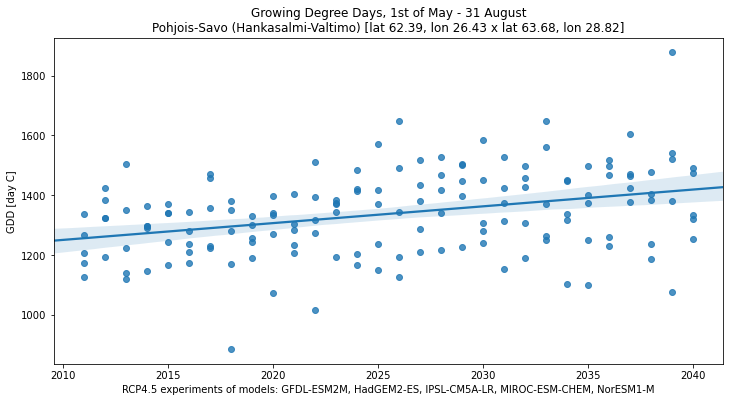

        model  year          GDD
0  GFDL-ESM2M  2011  1114.564209
1  GFDL-ESM2M  2012  1237.704773
2  GFDL-ESM2M  2013  1175.158488
3  GFDL-ESM2M  2014  1287.736613
4  GFDL-ESM2M  2015  1311.949361


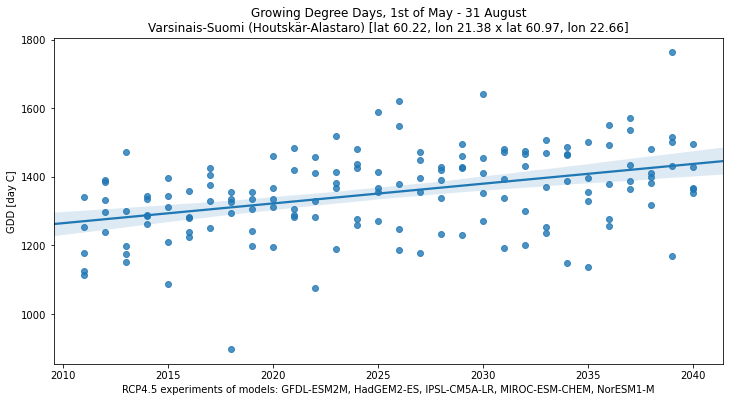

In [262]:
var_name = 'Growing Degree Days, 1st of May - 31 August'
var_unit = 'day C'
df_grp = df.loc[df['region'] == 'hame'].groupby(['model', 'year'], as_index=False)['GDD'].sum()
quick_plot_accum(df_grp, 'year', 'GDD', geo_hame, var_name, var_unit, '')
df_grp = df.loc[df['region'] == 'psavo'].groupby(['model', 'year'], as_index=False)['GDD'].sum()
quick_plot_accum(df_grp, 'year', 'GDD', geo_psavo, var_name, var_unit, '')
df_grp = df.loc[df['region'] == 'vsuomi'].groupby(['model', 'year'], as_index=False)['GDD'].sum()
quick_plot_accum(df_grp, 'year', 'GDD', geo_vsuomi, var_name, var_unit, '')